In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance, DMatrix
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample


from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs()

Using TensorFlow backend.


## Get the data
 - Andrew has put the data from two timesteps into CSVs


In [359]:
ts_1 = pd.read_csv("./data/training_data.csv")
ts_2 = pd.read_csv("./data/validation_data.csv")
data = pd.concat([ts_1, ts_2])
data.drop("Unnamed: 0", axis=1, inplace=True)
data

,relvort2_vert_avg,div2_vert_avg,def_rate2_vert_avg,MKE_vert_avg,isopycnal_slope_vert_avg,prandtl_ratio_vert_avg,absolute_momentum_slope_vert_avg,wind_stress,EKE_vert_avg
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000016,0.000000,0.041875,0.000000,0.000012,0.000016
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000011,0.000000,0.069212,0.000000,0.000065,0.000043
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000016,0.000000,0.024151,0.000000,0.000049,0.000057
3,1.151357e-11,3.817518e-12,8.908338e-12,0.000038,0.039960,0.018656,0.348576,0.000042,0.000046
4,4.800640e-12,2.059443e-13,2.355639e-11,0.000071,0.040996,0.032652,0.471641,0.000114,0.000034
...,...,...,...,...,...,...,...,...,...
56165,0.000000e+00,0.000000e+00,0.000000e+00,0.000009,0.000000,0.047374,0.000000,0.000032,0.000001
56166,0.000000e+00,0.000000e+00,0.000000e+00,0.000072,0.000000,0.104624,0.000000,0.000116,0.000039
56167,7.207366e-13,1.150684e-12,2.996360e-12,0.000050,0.490899,0.028613,0.101556,0.000445,0.000104
56168,6.041336e-12,3.779056e-13,4.414306e-12,0.000009,0.117387,0.003578,0.329086,0.000301,0.000106


## Look at the Data
 - Number of features available and number of samples by grid point
 - Make sure we dont have any null rows

In [360]:
print('Number of features: {}'.format(data.shape[1]-1))
print('Number of examples: {}'.format(data.shape[0]))

Number of features: 8
Number of examples: 112340


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112340 entries, 0 to 56169
Data columns (total 9 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   relvort2_vert_avg                 112340 non-null  float64
 1   div2_vert_avg                     112340 non-null  float64
 2   def_rate2_vert_avg                112340 non-null  float64
 3   MKE_vert_avg                      112340 non-null  float64
 4   isopycnal_slope_vert_avg          112340 non-null  float64
 5   prandtl_ratio_vert_avg            112340 non-null  float64
 6   absolute_momentum_slope_vert_avg  112340 non-null  float64
 7   wind_stress                       112340 non-null  float64
 8   EKE_vert_avg                      112340 non-null  float64
dtypes: float64(9)
memory usage: 8.6 MB


In [5]:
data.isna().sum()

relvort2_vert_avg                   0
div2_vert_avg                       0
def_rate2_vert_avg                  0
MKE_vert_avg                        0
isopycnal_slope_vert_avg            0
prandtl_ratio_vert_avg              0
absolute_momentum_slope_vert_avg    0
wind_stress                         0
EKE_vert_avg                        0
dtype: int64

In [362]:
data = data[data > 0]
data = data.dropna()
data

,relvort2_vert_avg,div2_vert_avg,def_rate2_vert_avg,MKE_vert_avg,isopycnal_slope_vert_avg,prandtl_ratio_vert_avg,absolute_momentum_slope_vert_avg,wind_stress,EKE_vert_avg
3,1.151357e-11,3.817518e-12,8.908338e-12,0.000038,0.039960,0.018656,0.348576,0.000042,0.000046
4,4.800640e-12,2.059443e-13,2.355639e-11,0.000071,0.040996,0.032652,0.471641,0.000114,0.000034
5,1.152439e-11,2.739279e-13,4.062157e-12,0.000058,0.056483,0.031821,0.632754,0.000734,0.000043
6,2.026905e-11,1.361116e-12,1.352364e-11,0.000106,0.075750,0.043777,0.498760,0.000234,0.000076
7,4.735783e-11,7.437052e-13,1.280111e-11,0.000128,0.070124,0.091883,1.157002,0.000377,0.000145
...,...,...,...,...,...,...,...,...,...
56162,2.473322e-11,1.636574e-12,1.837488e-11,0.000045,0.020153,0.000800,0.100340,0.000166,0.000198
56163,6.626087e-12,9.812617e-13,7.975129e-13,0.000111,0.005154,0.001236,0.101671,0.000489,0.000120
56164,3.685502e-12,1.929110e-13,4.967039e-12,0.000170,0.163507,0.005469,0.010942,0.000176,0.000048
56167,7.207366e-13,1.150684e-12,2.996360e-12,0.000050,0.490899,0.028613,0.101556,0.000445,0.000104


In [363]:
data_info = data.describe()
data_info = data_info.transpose()
data_info

,count,mean,std,min,25%,50%,75%,max
relvort2_vert_avg,106324.0,6.402318e-11,2.660006e-10,1.553285e-15,1.914471e-12,7.278166e-12,3.283813e-11,2.878286e-08
div2_vert_avg,106324.0,4.726971e-12,2.788882e-11,4.331590e-16,2.024009e-13,7.000142e-13,2.823049e-12,4.520676e-09
def_rate2_vert_avg,106324.0,6.942458e-11,2.255570e-10,3.018661e-14,3.022177e-12,1.064137e-11,4.467638e-11,2.076133e-08
MKE_vert_avg,106324.0,2.677905e-03,1.310207e-02,5.384786e-09,1.342085e-04,4.058875e-04,1.500662e-03,1.419584e+00
isopycnal_slope_vert_avg,106324.0,6.131095e-02,3.831453e-01,3.508475e-05,3.912609e-03,8.818538e-03,2.339628e-02,3.348683e+01
prandtl_ratio_vert_avg,106324.0,4.021189e-02,4.488822e-02,2.691169e-09,6.207847e-03,2.280464e-02,6.139676e-02,6.452073e-01
absolute_momentum_slope_vert_avg,106324.0,5.848552e+00,1.161463e+01,2.758060e-07,4.863253e-01,2.488374e+00,6.916463e+00,4.099206e+02
wind_stress,106324.0,9.093269e-03,8.010808e-03,2.037154e-06,3.689458e-03,6.844423e-03,1.223074e-02,1.143918e-01
EKE_vert_avg,106324.0,1.565677e-03,4.874375e-03,5.985099e-09,2.032635e-04,4.473248e-04,1.214825e-03,3.400448e-01


In [364]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106324 entries, 3 to 56168
Data columns (total 9 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   relvort2_vert_avg                 106324 non-null  float64
 1   div2_vert_avg                     106324 non-null  float64
 2   def_rate2_vert_avg                106324 non-null  float64
 3   MKE_vert_avg                      106324 non-null  float64
 4   isopycnal_slope_vert_avg          106324 non-null  float64
 5   prandtl_ratio_vert_avg            106324 non-null  float64
 6   absolute_momentum_slope_vert_avg  106324 non-null  float64
 7   wind_stress                       106324 non-null  float64
 8   EKE_vert_avg                      106324 non-null  float64
dtypes: float64(9)
memory usage: 8.1 MB


## Plot some correlations and pairwise distributions

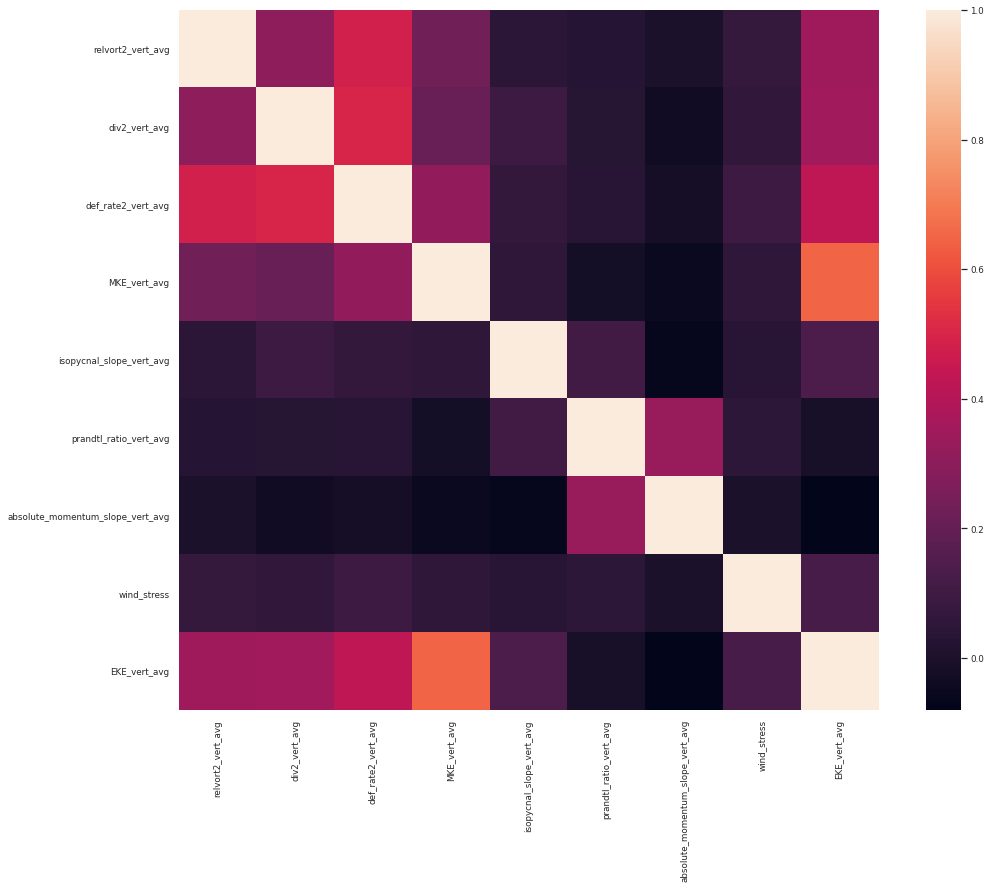

In [365]:
corrmatrix = data.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=1, square=True)
sns.set(font_scale=0.8)

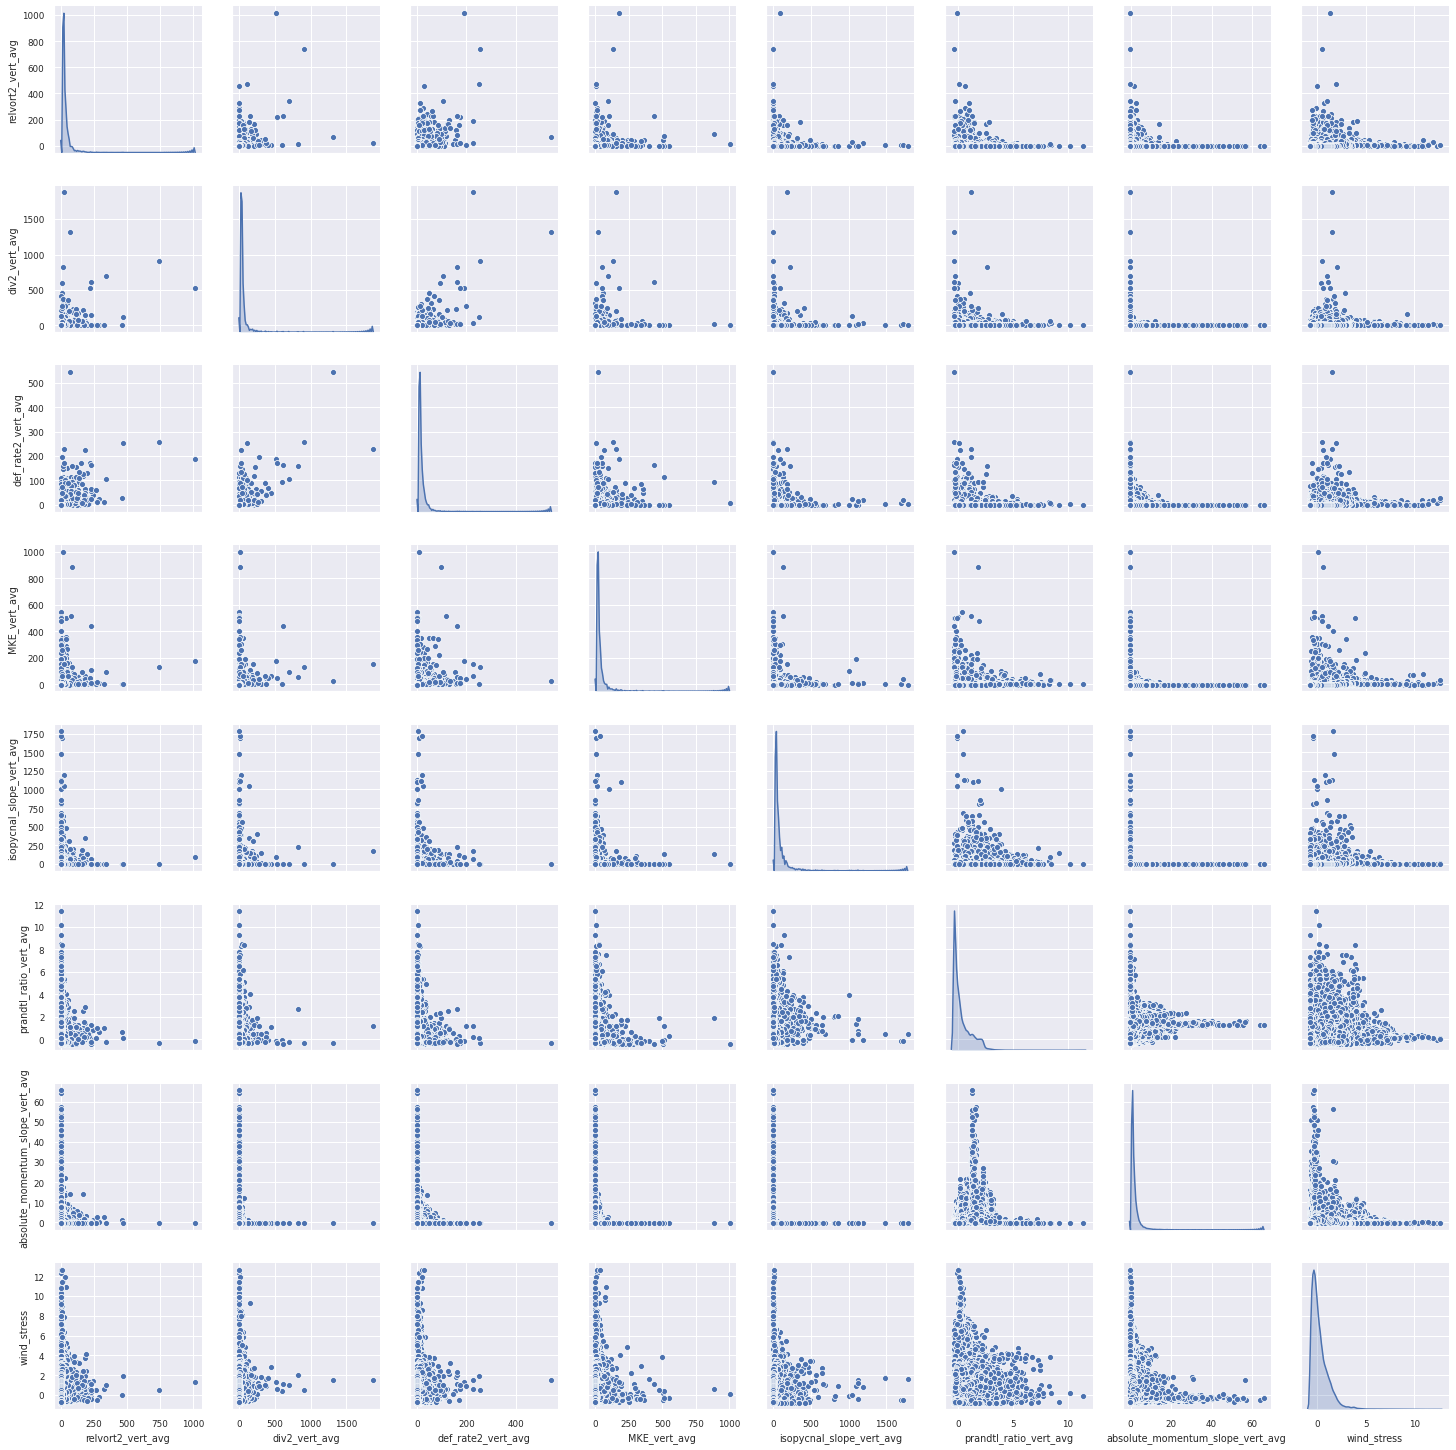

In [344]:
sns.pairplot(data[["relvort2_vert_avg","div2_vert_avg","def_rate2_vert_avg", "MKE_vert_avg","isopycnal_slope_vert_avg", "prandtl_ratio_vert_avg","absolute_momentum_slope_vert_avg","wind_stress"]], diag_kind="kde")

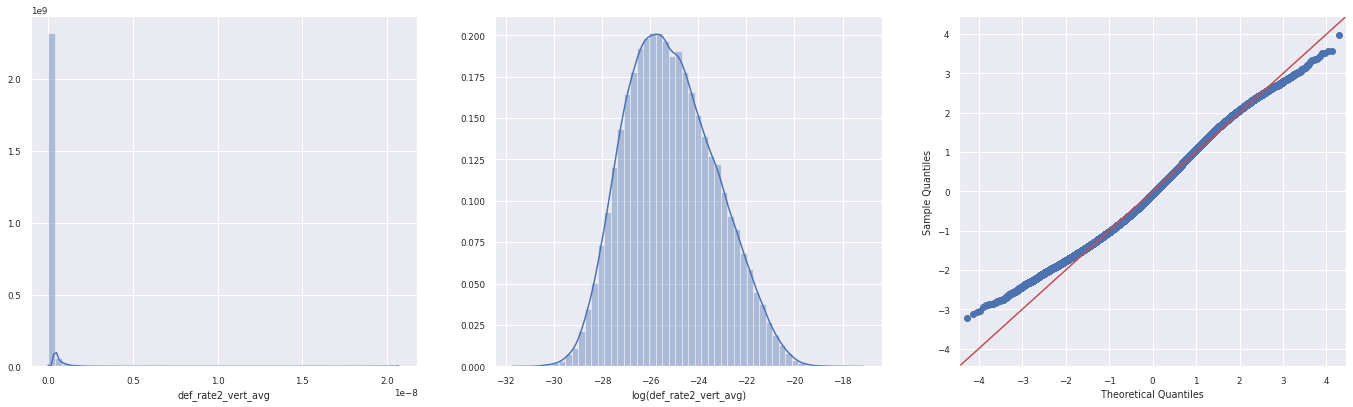

In [366]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['def_rate2_vert_avg'], ax=axes[0])
sns.distplot(np.log(data['def_rate2_vert_avg']), ax=axes[1])
axes[1].set_xlabel('log(def_rate2_vert_avg)')
sm.qqplot(np.log(data['def_rate2_vert_avg']), stats.norm, fit=True, line='45', ax=axes[2])
fig.show()

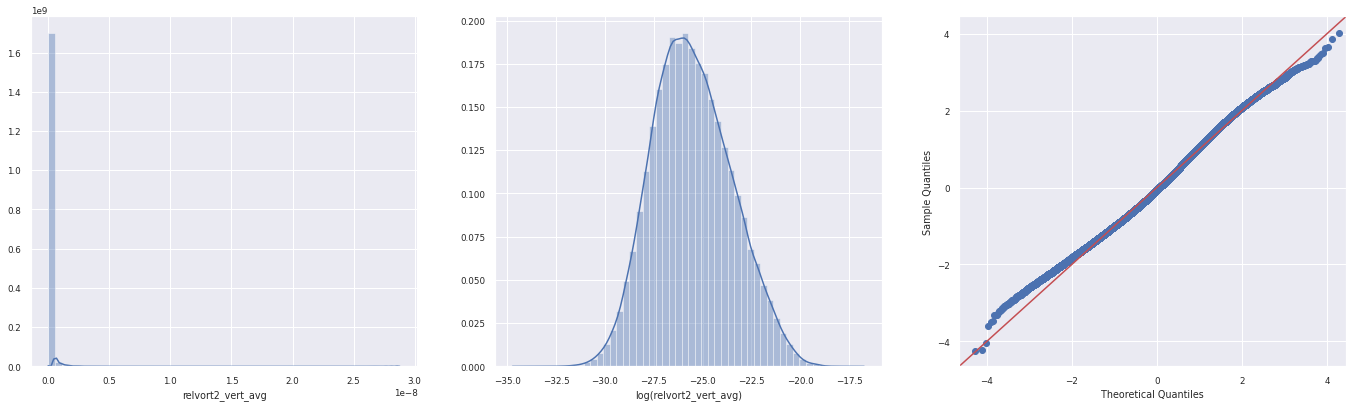

In [64]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['relvort2_vert_avg'], ax=axes[0])
sns.distplot(np.log(data['relvort2_vert_avg']), ax=axes[1])
axes[1].set_xlabel('log(relvort2_vert_avg)')
sm.qqplot(np.log(data["relvort2_vert_avg"]), stats.norm, fit=True, line='45', ax=axes[2])
fig.show()

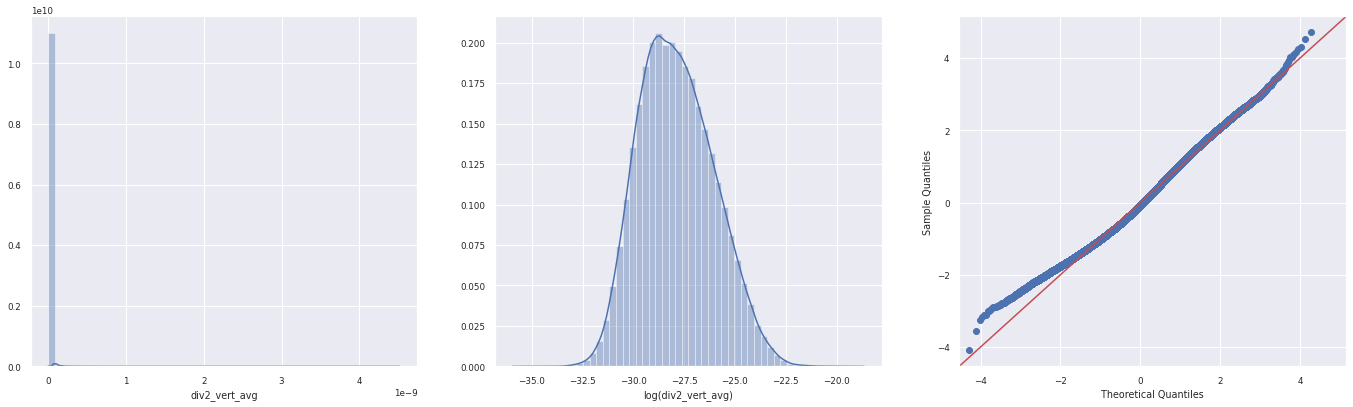

In [65]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['div2_vert_avg'], ax=axes[0])
sns.distplot(np.log(data['div2_vert_avg']), ax=axes[1])
axes[1].set_xlabel('log(div2_vert_avg)')
sm.qqplot(np.log(data["div2_vert_avg"]), stats.norm, fit=True, line='45', ax=axes[2])
fig.show()

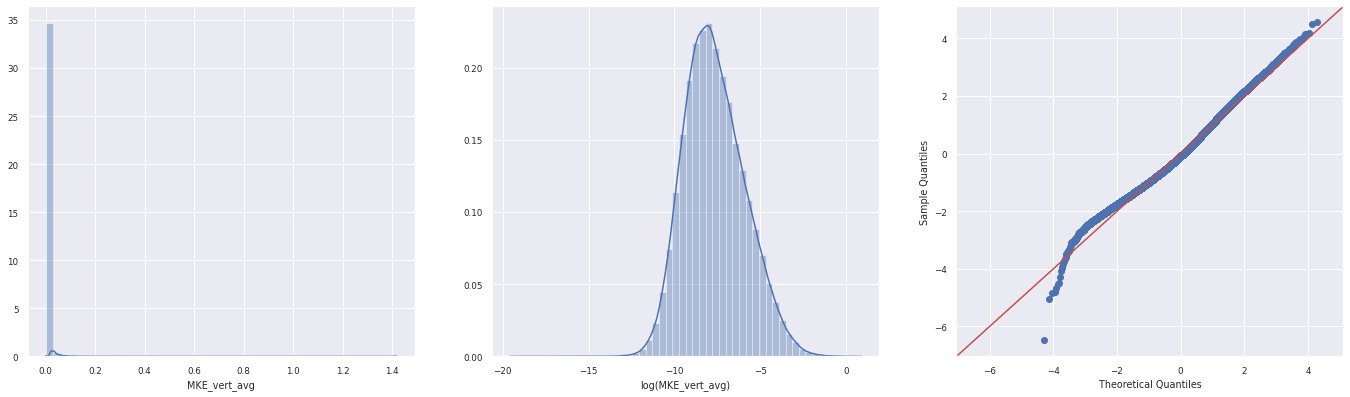

In [66]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['MKE_vert_avg'], ax=axes[0])
sns.distplot(np.log(data['MKE_vert_avg']), ax=axes[1])
axes[1].set_xlabel('log(MKE_vert_avg)')
sm.qqplot(np.log(data["MKE_vert_avg"]), stats.norm, fit=True, line='45', ax=axes[2])
fig.show()

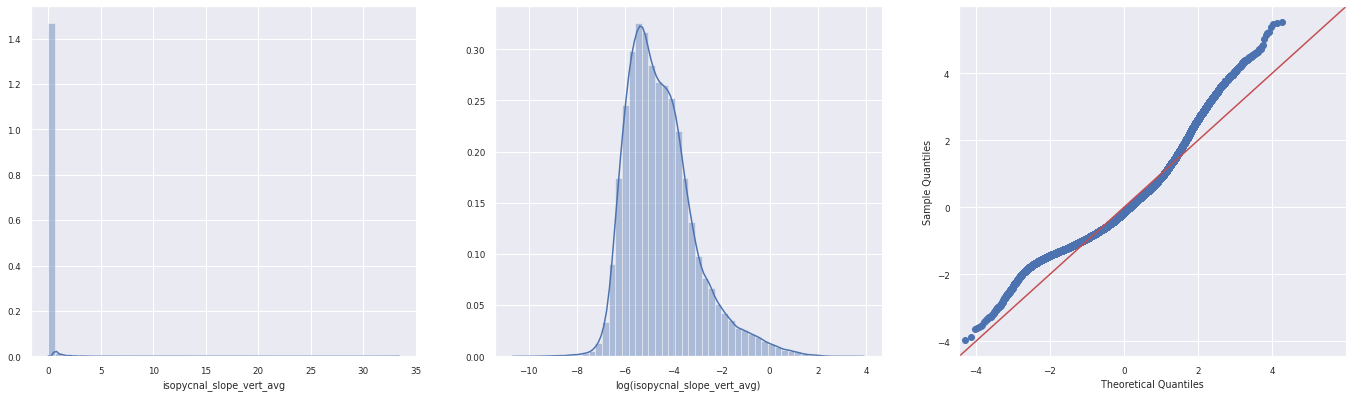

In [67]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['isopycnal_slope_vert_avg'], ax=axes[0])
sns.distplot(np.log(data['isopycnal_slope_vert_avg']), ax=axes[1])
axes[1].set_xlabel('log(isopycnal_slope_vert_avg)')
sm.qqplot(np.log(data["isopycnal_slope_vert_avg"]), stats.norm, fit=True, line='45', ax=axes[2])
fig.show()

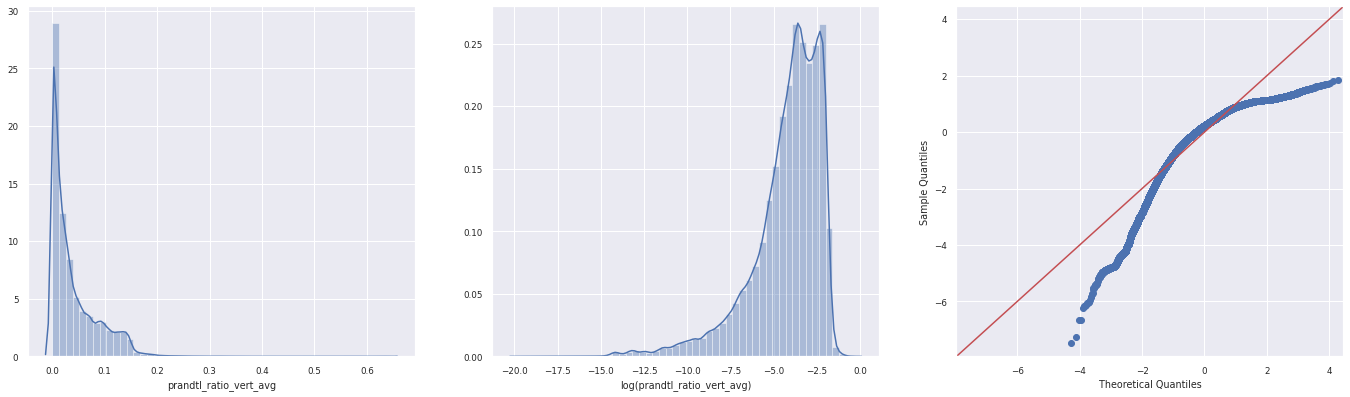

In [70]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['prandtl_ratio_vert_avg'], ax=axes[0])
sns.distplot(np.log(data['prandtl_ratio_vert_avg']), ax=axes[1])
axes[1].set_xlabel('log(prandtl_ratio_vert_avg)')
sm.qqplot(np.log(data["prandtl_ratio_vert_avg"]), stats.norm, fit=True, line='45', ax=axes[2])
fig.show()

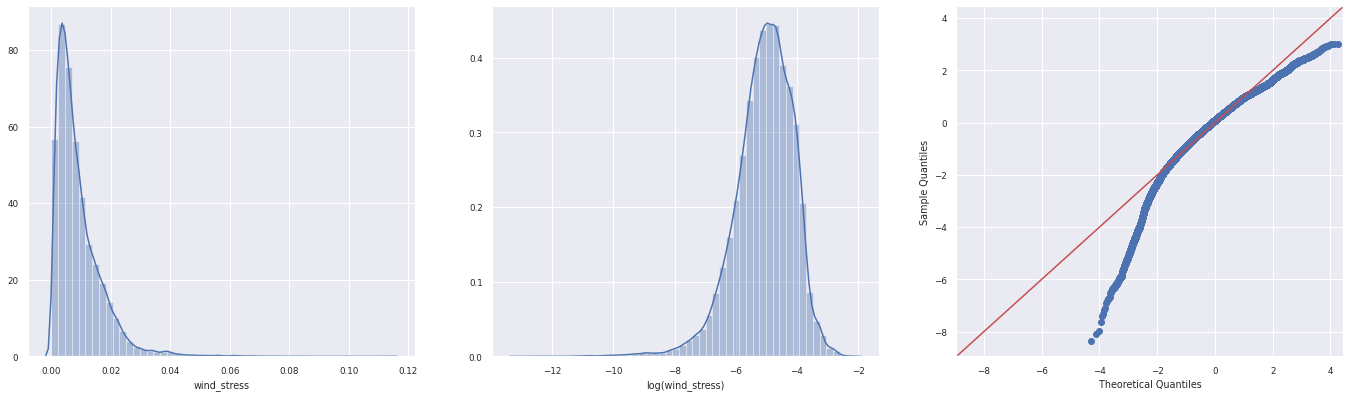

In [71]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['wind_stress'], ax=axes[0])
sns.distplot(np.log(data["wind_stress"]), ax=axes[1])
axes[1].set_xlabel('log(wind_stress)')
sm.qqplot(np.log(data["wind_stress"]), stats.norm, fit=True, line='45', ax=axes[2])
fig.show()

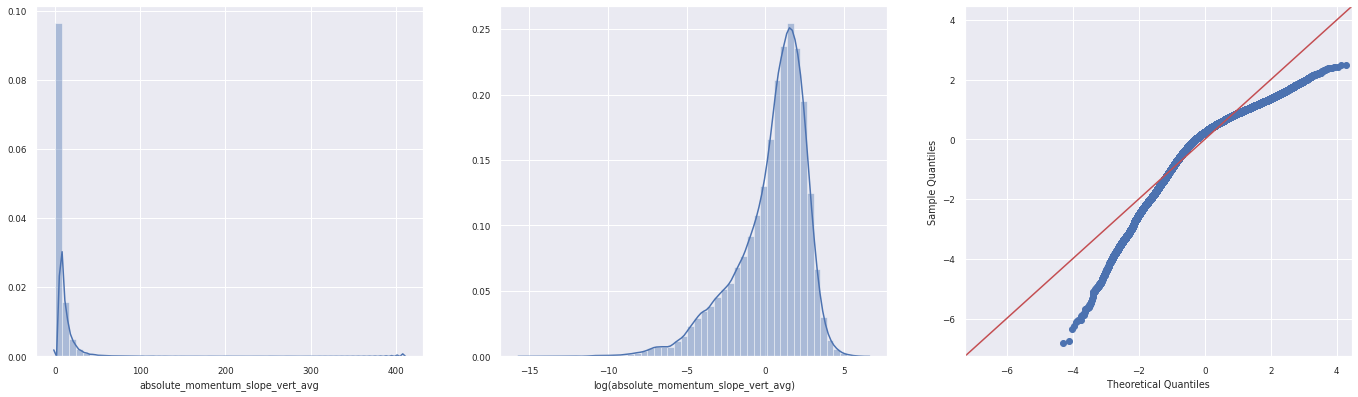

In [74]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['absolute_momentum_slope_vert_avg'], ax=axes[0])
sns.distplot(np.log(data["absolute_momentum_slope_vert_avg"]), ax=axes[1])
axes[1].set_xlabel('log(absolute_momentum_slope_vert_avg)')
sm.qqplot(np.log(data["absolute_momentum_slope_vert_avg"]), stats.norm, fit=True, line='45', ax=axes[2])
fig.show()

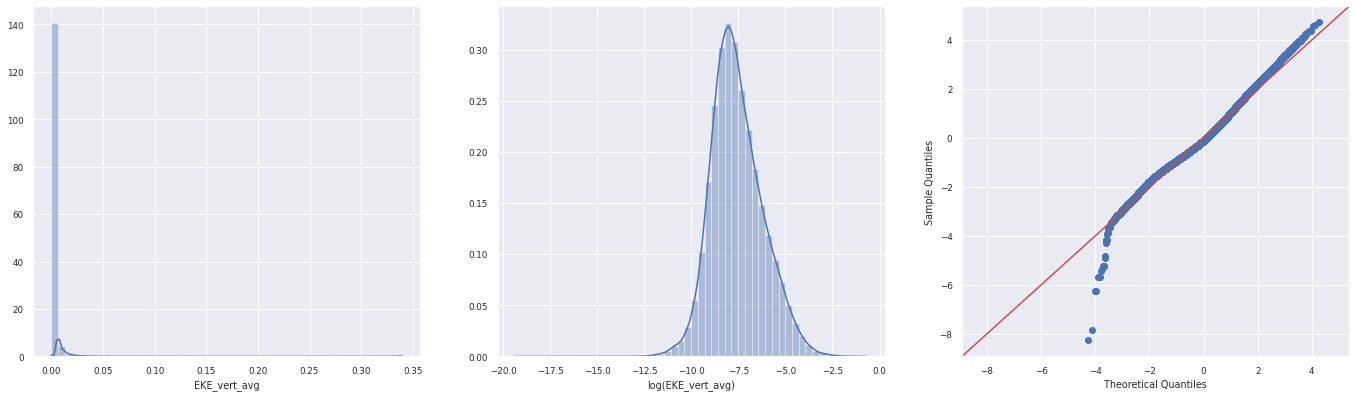

In [75]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['EKE_vert_avg'], ax=axes[0])
sns.distplot(np.log(data["EKE_vert_avg"]), ax=axes[1])
axes[1].set_xlabel('log(EKE_vert_avg)')
sm.qqplot(np.log(data["EKE_vert_avg"]), stats.norm, fit=True, line='45', ax=axes[2])
fig.show()

In [367]:
data["def_rate2_vert_avg"] = np.log(data["def_rate2_vert_avg"])
data["relvort2_vert_avg"] = np.log(data["relvort2_vert_avg"])
data["div2_vert_avg"] = np.log(data["div2_vert_avg"])
data["MKE_vert_avg"] = np.log(data["MKE_vert_avg"])
data["isopycnal_slope_vert_avg"] = np.log(data["isopycnal_slope_vert_avg"])
data["prandtl_ratio_vert_avg"] = np.log(data["prandtl_ratio_vert_avg"])
data["wind_stress"] = np.log(data["wind_stress"])
data["absolute_momentum_slope_vert_avg"] = np.log(data["absolute_momentum_slope_vert_avg"])
data["EKE_vert_avg"] = np.log(data["EKE_vert_avg"])


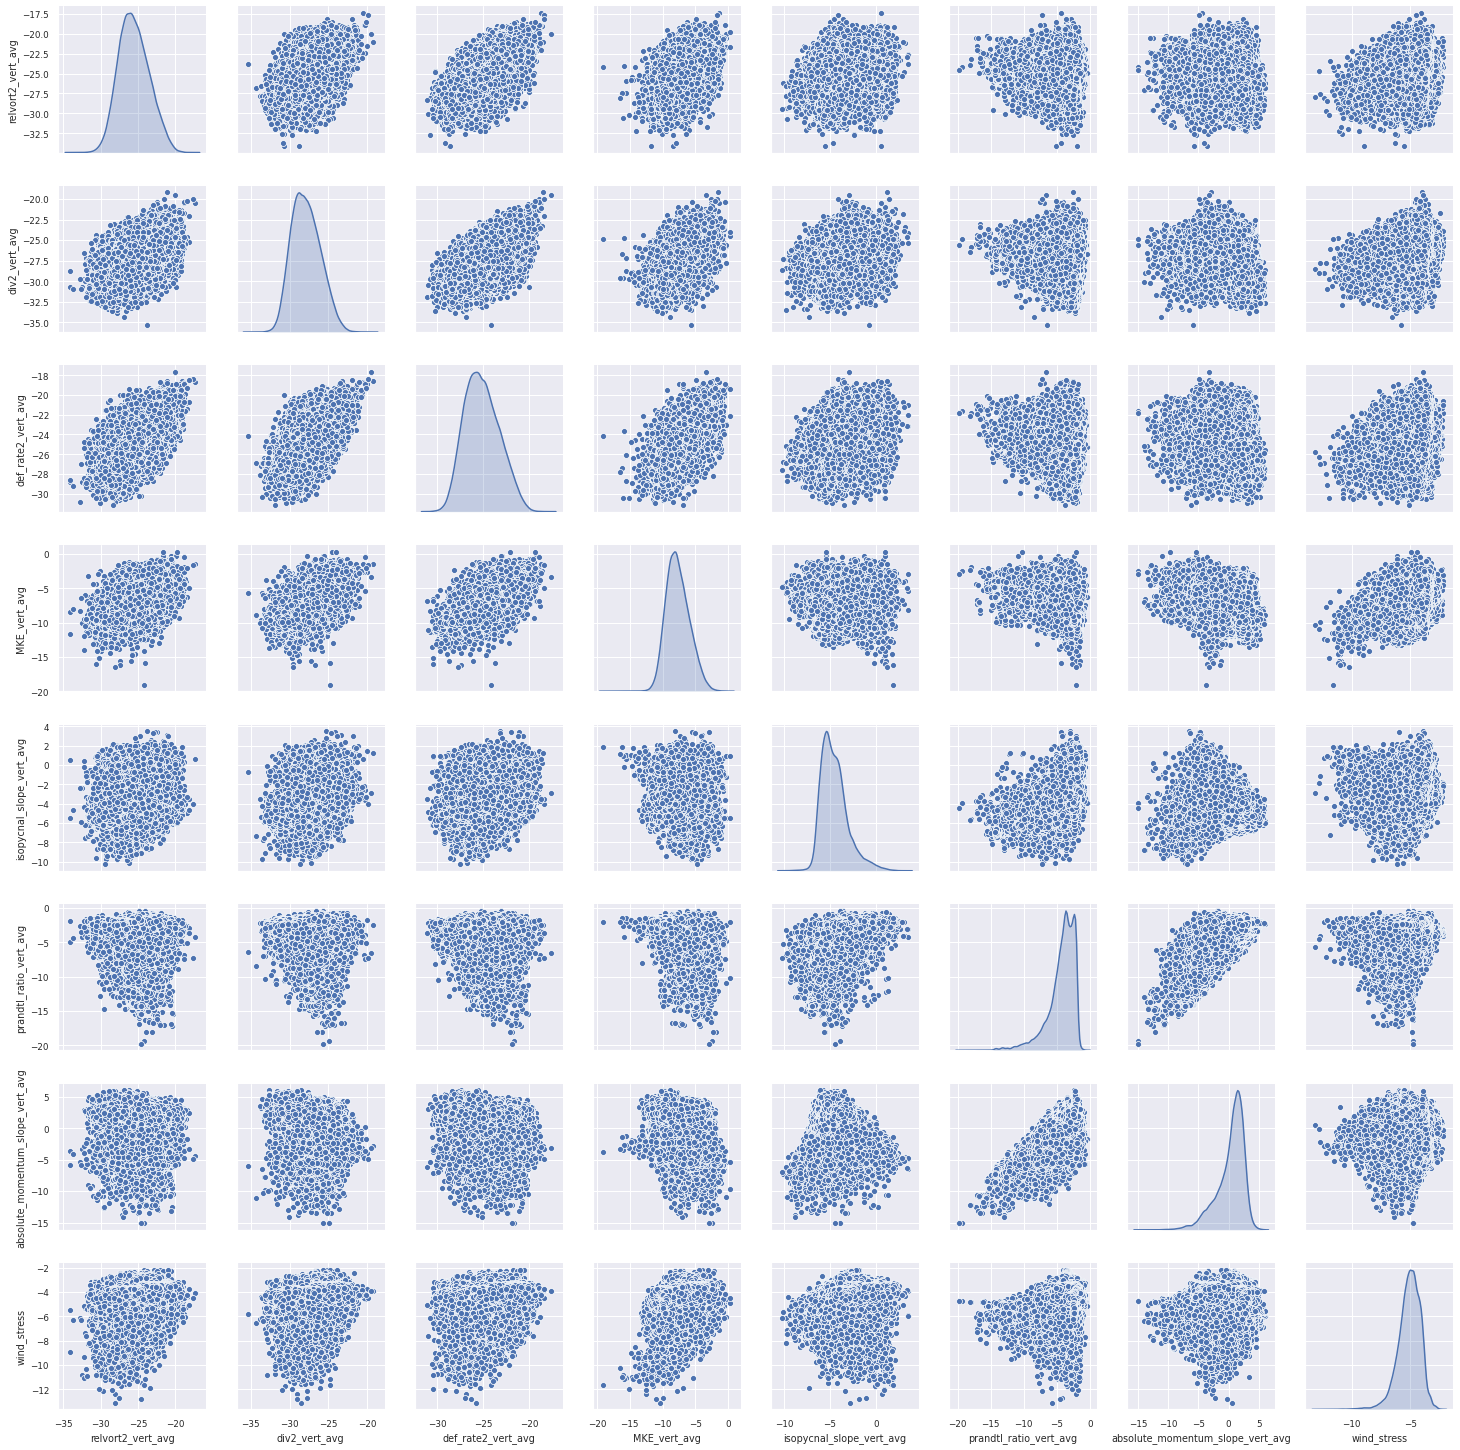

In [368]:
sns.pairplot(data[["relvort2_vert_avg","div2_vert_avg","def_rate2_vert_avg", "MKE_vert_avg","isopycnal_slope_vert_avg", "prandtl_ratio_vert_avg","absolute_momentum_slope_vert_avg","wind_stress"]], diag_kind="kde")